# Regressão Random Forest

### 1. Configuração Inicial

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Importações do scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
%matplotlib inline

### 2. Carregamento dos Dados

In [20]:
print("Carregando os dados...")
data_dir = Path('../data/raw')
train_path = data_dir / 'train.csv'
test_path = data_dir / 'test.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Dados de treino carregados: {train_df.shape}")
    print(f"Dados de teste carregados: {test_df.shape}")
except Exception as e:
    print(f"Erro ao carregar os dados: {e}")
    raise

Carregando os dados...
Dados de treino carregados: (1460, 81)
Dados de teste carregados: (1459, 80)


### 3. Análise Exploratória de Dados (EDA)

In [21]:
print("\nAnálise Exploratória de Dados...")

# Visualização das primeiras linhas
print("\nVisualizando as primeiras linhas do conjunto de treino:")
display(train_df.head())

# Estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
display(train_df.describe())

# Verificando valores ausentes
print("\nValores ausentes por coluna (treino):")
missing_train = train_df.isnull().sum().sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
display(missing_train)


Análise Exploratória de Dados...

Visualizando as primeiras linhas do conjunto de treino:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Estatísticas descritivas das variáveis numéricas:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



Valores ausentes por coluna (treino):


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

### 4. Pré-processamento dos Dados

In [22]:
print("\nPré-processando os dados...")

# Separando features e target
X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']
X_test_sub = test_df.drop('Id', axis=1)

# Identificando colunas numéricas e categóricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Definindo transformações
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinando transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicando transformações
print("Aplicando transformações...")
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_sub)

# Obtendo os nomes das features após o pré-processamento
numeric_features = list(numeric_cols)
categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
feature_names = numeric_features + categorical_features

# Dividindo em conjuntos de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print(f"\nShape dos dados processados:")
print(f"- Treino: {X_train.shape}")
print(f"- Validação: {X_val.shape}")
print(f"- Teste: {X_test_processed.shape}")


Pré-processando os dados...
Aplicando transformações...

Shape dos dados processados:
- Treino: (1168, 287)
- Validação: (292, 287)
- Teste: (1459, 287)


### 5. Treinamento do Modelo Random Forest

In [23]:
print("\nTreinando o modelo Random Forest...")

# Criando o modelo base
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Treinando o modelo
rf_model.fit(X_train, y_train)

# Função para avaliação do modelo
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\nMétricas para {dataset_name}:")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R²: {r2:.4f}")
    print(f"  - MAE: {mae:.2f}")
    
    return rmse, r2, mae

# Fazendo previsões
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Avaliando o modelo
print("\nAvaliação do Modelo Base:")
train_metrics = evaluate_model(y_train, y_train_pred, "Treino")
val_metrics = evaluate_model(y_val, y_val_pred, "Validação")


Treinando o modelo Random Forest...

Avaliação do Modelo Base:

Métricas para Treino:
  - RMSE: 11127.98
  - R²: 0.9792
  - MAE: 6549.62

Métricas para Validação:
  - RMSE: 28884.78
  - R²: 0.8912
  - MAE: 17642.26


### 6. Otimização de Hiperparâmetros

In [24]:
print("\nOtimizando hiperparâmetros...")

# Definindo a grade de parâmetros para busca
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Criando o modelo
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Busca em grade com validação cruzada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


Otimizando hiperparâmetros...


In [25]:
# Executando a busca
print("Iniciando busca em grade...")
grid_search.fit(X_train, y_train)

# Melhores parâmetros
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor modelo
best_rf = grid_search.best_estimator_

Iniciando busca em grade...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Melhores parâmetros encontrados:
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [26]:
# Avaliando o modelo otimizado
print("\nAvaliação do Modelo Otimizado:")
y_train_pred_opt = best_rf.predict(X_train)
y_val_pred_opt = best_rf.predict(X_val)

train_metrics_opt = evaluate_model(y_train, y_train_pred_opt, "Treino (Otimizado)")
val_metrics_opt = evaluate_model(y_val, y_val_pred_opt, "Validação (Otimizado)")



Avaliação do Modelo Otimizado:

Métricas para Treino (Otimizado):
  - RMSE: 11580.43
  - R²: 0.9775
  - MAE: 6659.70

Métricas para Validação (Otimizado):
  - RMSE: 32944.93
  - R²: 0.8585
  - MAE: 18462.04


### 7. Análise de Importância das Features


Analisando importância das features...


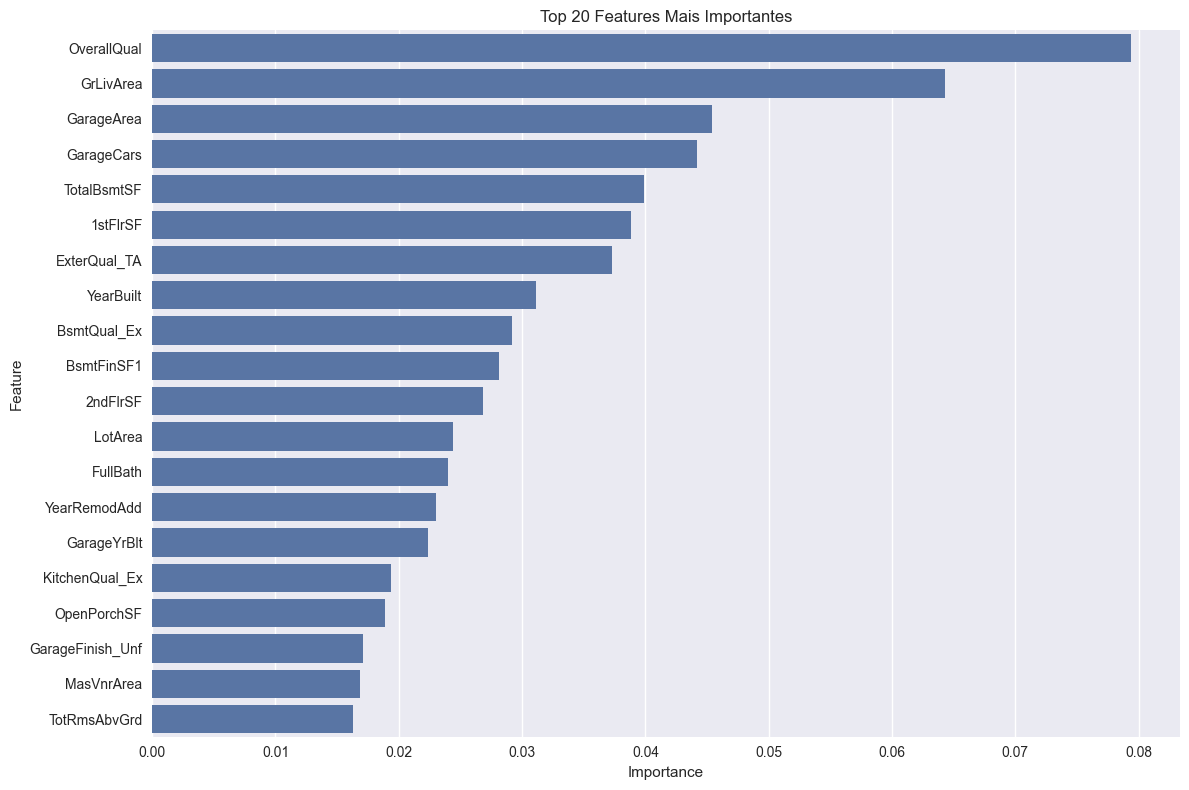

In [27]:
print("\nAnalisando importância das features...")

# Obtendo a importância das features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

# Plotando a importância das features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 20 Features Mais Importantes')
plt.tight_layout()
plt.savefig('../outputs/figures/feature_importance_rf.png')
plt.show()

### 8. Treinamento Final e Submissão

In [28]:
print("\nTreinando o modelo final com todos os dados de treino...")
final_model = RandomForestRegressor(**grid_search.best_params_, random_state=42, n_jobs=-1)
final_model.fit(X_processed, y)

# Fazendo previsões no conjunto de teste
print("Fazendo previsões no conjunto de teste...")
test_predictions = final_model.predict(X_test_processed)


Treinando o modelo final com todos os dados de treino...
Fazendo previsões no conjunto de teste...


In [29]:
# Criando o arquivo de submissão
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_predictions
})

In [30]:
# Salvando o arquivo de submissão
os.makedirs('../outputs', exist_ok=True)
submission_path = '../outputs/submission_random_forest.csv'
submission.to_csv(submission_path, index=False)
print(f"\nArquivo de submissão salvo em: {submission_path}")


Arquivo de submissão salvo em: ../outputs/submission_random_forest.csv


In [31]:
# Visualizando as primeiras linhas da submissão
print("\nVisualização das primeiras previsões:")
display(submission.head())


Visualização das primeiras previsões:


,Id,SalePrice
0,1461,127290.440
1,1462,155821.185
2,1463,181118.685
3,1464,190695.490
4,1465,191227.540


### 9. Análise de Overfitting e Underfitting

Avaliando com 10 árvores...
Avaliando com 50 árvores...
Avaliando com 100 árvores...
Avaliando com 200 árvores...
Avaliando com 300 árvores...
Avaliando com 400 árvores...
Avaliando com 500 árvores...


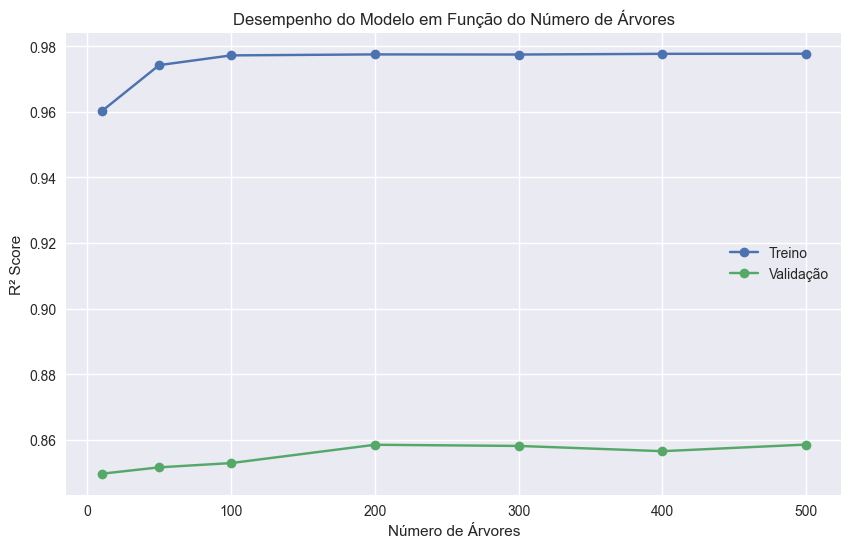

In [32]:
# Avaliando o desempenho em diferentes números de árvores
n_estimators = [10, 50, 100, 200, 300, 400, 500]
train_scores = []
val_scores = []

for n in n_estimators:
    print(f"Avaliando com {n} árvores...")
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=42,
        n_jobs=-1,
        **{k: v for k, v in grid_search.best_params_.items() if k != 'n_estimators'}
    )
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    val_scores.append(rf.score(X_val, y_val))

    # Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, train_scores, label='Treino', marker='o')
plt.plot(n_estimators, val_scores, label='Validação', marker='o')
plt.xlabel('Número de Árvores')
plt.ylabel('R² Score')
plt.title('Desempenho do Modelo em Função do Número de Árvores')
plt.legend()
plt.grid(True)
plt.savefig('../outputs/figures/n_estimators_analysis.png')
plt.show()

### 10. Salvando o Modelo

In [33]:
print("\nSalvando o modelo...")
import joblib

# Criando diretório de modelos se não existir
os.makedirs('../outputs/models', exist_ok=True)

# Salvando o modelo
model_path = '../outputs/models/random_forest_model.joblib'
joblib.dump(final_model, model_path)
print(f"Modelo salvo em: {model_path}")

# Salvando o pré-processador
preprocessor_path = '../outputs/models/random_forest_preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_path)
print(f"Pré-processador salvo em: {preprocessor_path}")


Salvando o modelo...
Modelo salvo em: ../outputs/models/random_forest_model.joblib
Pré-processador salvo em: ../outputs/models/random_forest_preprocessor.joblib
